# Hubble Ultra Deep Field Aperture Photometry

In [119]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [8, 8]

In [120]:
data = fits.open("C:/Users/brand/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
image_data = data[0].data

The mean of the image is 0.0007912990404292941 while the standard deviation of the image is 0.05486845225095749


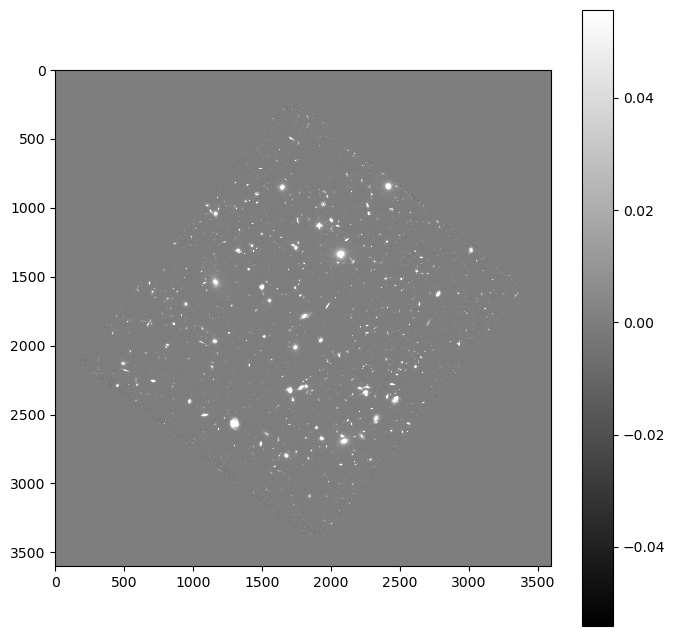

In [121]:
m, s = np.mean(image_data), np.std(image_data)
print(f"The mean of the image is {m} while the standard deviation of the image is {s}")
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='upper')
plt.colorbar();
plt.show()
plt.savefig("hudf_fit1.png")

In [122]:
image_data = image_data.byteswap().newbyteorder() # encountered a error about non-native byte order
bkg = sep.Background(image_data)
print(f"The global background level is {bkg.globalback}")
print(f"The root means square of the background noise is {bkg.globalrms}")

The global background level is 0.0
The root means square of the background noise is 0.0005398219218477607


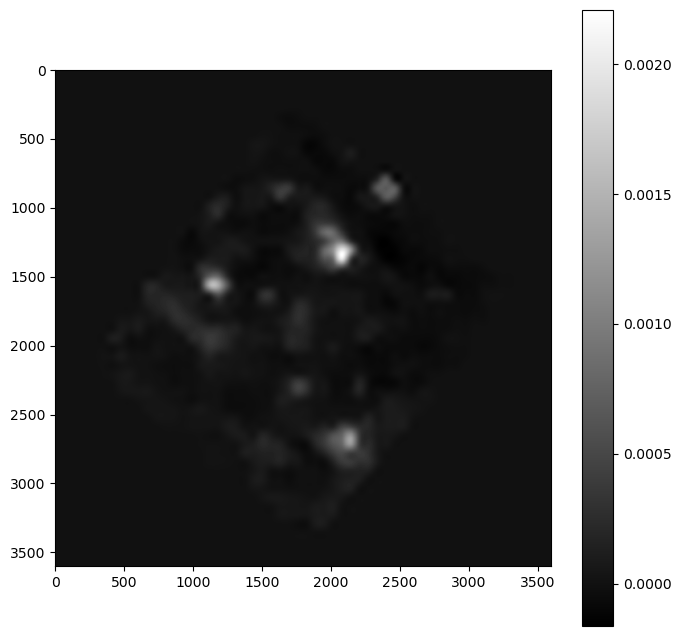

In [123]:
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='upper')
plt.colorbar();
plt.show()
plt.savefig("hudf_fit2.png")

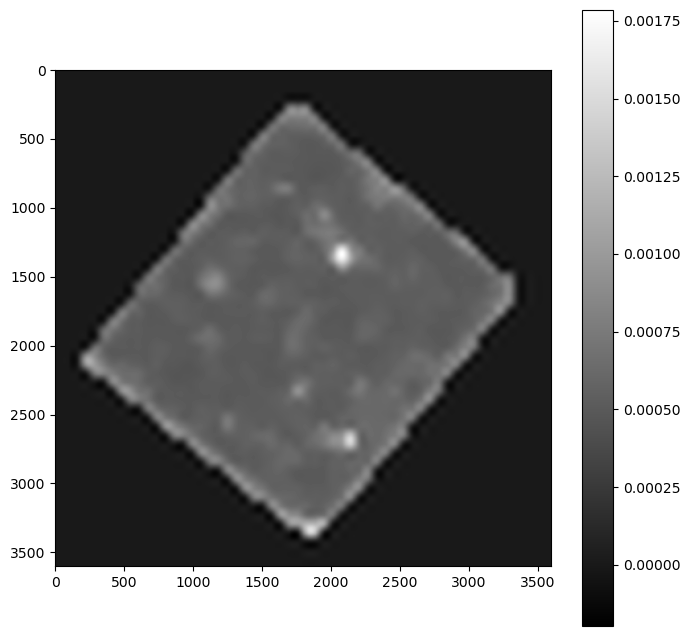

In [124]:
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='upper')
plt.colorbar();
plt.show()
plt.savefig("hudf_fit3.png")

In [125]:
data_sub = image_data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
print(f"There are approximately {len(objects)} sources in the UDF image.")

There are approximately 8627 sources in the UDF image.


<Figure size 800x800 with 0 Axes>

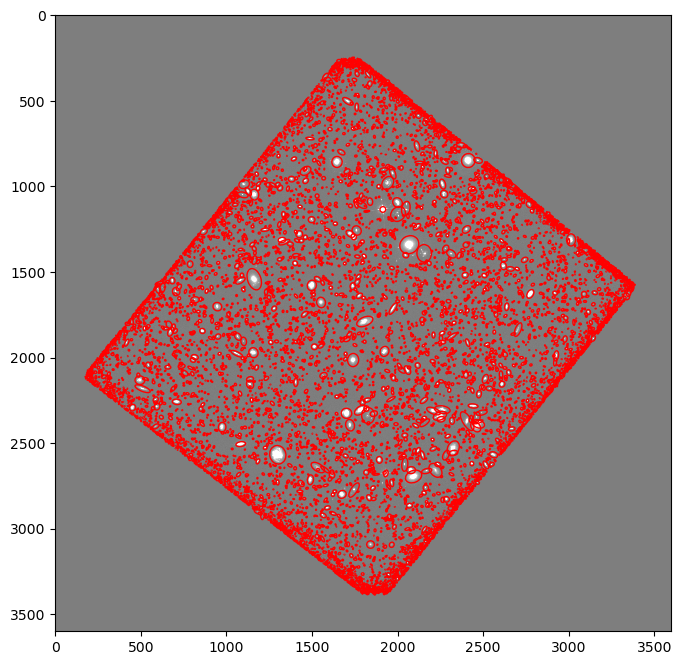

In [126]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='upper')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.show()
plt.savefig("hudf_fit4.png")

In [127]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [128]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


# Histogram of Fluxes

This code creates a histogram of the flux values of detected objects, visualizing the distribution of their fluxes.

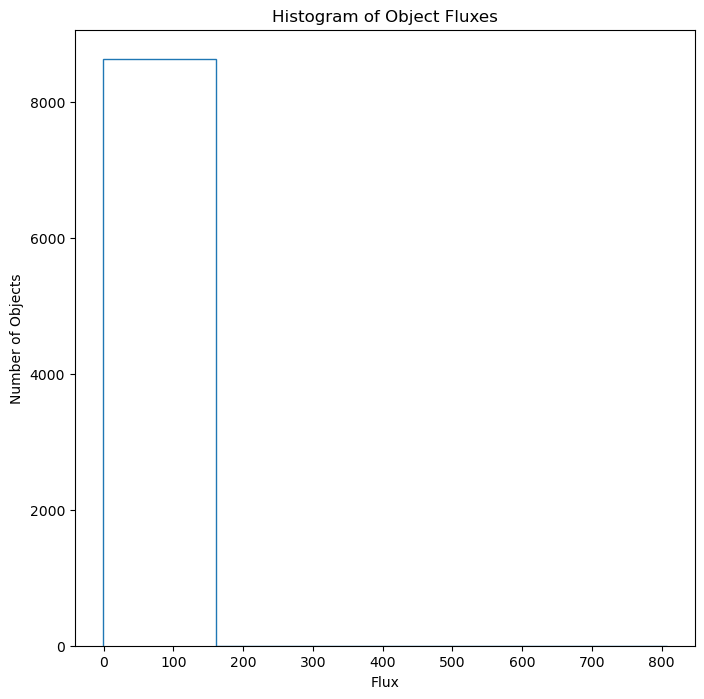

In [129]:
#extracting the flux values of the detected objects
#fluxes = objects['flux']

plt.hist(flux, bins=5, facecolor='gray', histtype='step')
plt.xlabel('Flux')
plt.ylabel('Number of Objects')
plt.title('Histogram of Object Fluxes')
plt.show()

# Calculating Mean, Median, & Standard Deviation of the Distribution of Fluxes

This code calculates the statistical properties of the flux distribution, including the mean, median, and standard deviation. It identifies the largest outlier in the flux values, determines its position on the image (x, y coordinates), and computes how many standard deviations it is away from the mean.

In [130]:
# calculating mean, median, and std
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)

# finding largest outlier and its position
maxf = np.max(flux)
outlier = np.argmax(flux)  # largest outlier
outlier_x = objects['x'][outlier]
outlier_y = objects['y'][outlier]
num_std = (maxf - mean) / std

print(f"Mean flux: {mean}")
print(f"Median flux: {median}")
print(f"Standard deviation of flux: {std}")
print(f"Largest outlier flux: {maxf}")
print(f"Outlier position (x, y): ({outlier_x}, {outlier_y})")
print(f"Outlier is {num_std:.2f} standard deviations away from the mean.")

Mean flux: 0.3623801392249136
Median flux: 0.031014466641936456
Standard deviation of flux: 9.250480108433536
Largest outlier flux: 807.2972835731507
Outlier position (x, y): (1914.2549094883857, 1134.3164850742164)
Outlier is 87.23 standard deviations away from the mean.


# 3-Color False Image

This code creates a 3-color composite image of the Hubble Ultra Deep Field by combining data from three filters (f160w, f125w, and f105w) into RGB channels. Each image is normalized using a logarithmic scale to enhance visibility, stacked into an RGB array, and displayed

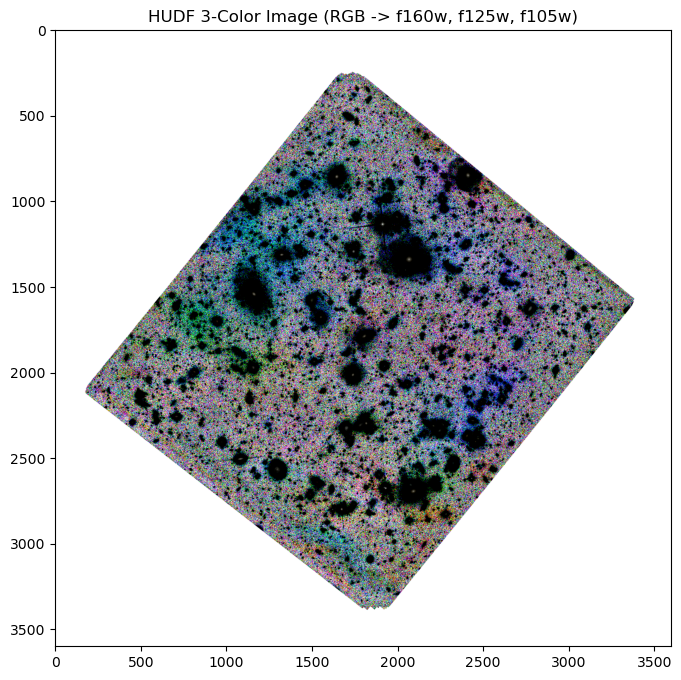

In [131]:
from matplotlib.colors import LogNorm

# returns the 2d array instead of opening the file
f160w = fits.getdata("C:/Users/brand/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
f125w = fits.getdata("C:/Users/brand/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
f105w = fits.getdata("C:/Users/brand/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

# normalizes an image array to a range of 0 to 1 using a logarithmic scale, enhancing visibility by compressing the dynamic range.
# useful for images with high contrast because it preserves details across wide intensity ranges.
def normalize_image(image, stretch=LogNorm(vmin=0.1, vmax=100)):
    norm = stretch(image) # transforms pixel values into a logarithmic scale between 0 and 1
    norm = np.clip(norm, 0, 1)
    return norm # returns the normalized and clipped version of input image

# sets images to rgb colors
red = normalize_image(f160w)
green = normalize_image(f125w)
blue = normalize_image(f105w)

rgb_image = np.dstack((red, green, blue)) #combines the three 2D arrays into a single 3D array

plt.imshow(rgb_image, origin='upper')
plt.title("HUDF 3-Color Image (RGB -> f160w, f125w, f105w)")
plt.savefig("hudf_rgb.png")
plt.show()